#Task

Get acquainted with the dataset by the link

Download the dataset

Perform primary data analysis (column types, gaps, number of rows...)

Conduct visual data analysis (build graphs, determine whether there    is a correlation between data)

If necessary, create new features.

Train the recommendation system.

Make several recommendations for random users from the dataset

#import libraries

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import os
import glob
import re


from sklearn.manifold import TSNE

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import OneHotEncoder


#Parsing data

Since it is impossible to read the table properly due to the different number user sessions, I decided to determine the number of columns in each file and add them as a separate dataframe to the dictionary, and then do the concatenation.

In [3]:
# define directory with files which need to merge
dir = "/content/drive/MyDrive/Hillel_ML_Course/10/entree/session"

# files list from directory
files = list(glob.glob(os.path.join(dir,'*.*')))

In [4]:
chicago_path = "/content/drive/MyDrive/Hillel_ML_Course/10/entree/data/chicago.txt"

In [5]:
chicago_table = pd.read_csv(chicago_path, header=None, names=["id", "name", "features"], delimiter='\t',)

In [6]:
#function to convert object features to integers list
def features_to_int(text):
  int_list = []
  splitted_text = text.split()
  for i in splitted_text:
    int_list.append(int(i))
  return np.array(int_list, dtype=int)

In [7]:
chicago_table['features'] = chicago_table['features'].apply(lambda x: list(map(int, str(x).split())))
feature_columns = pd.DataFrame(chicago_table['features'].tolist())

In [8]:
feature_columns = feature_columns.fillna(0)

In [9]:
feature_columns

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,214,35,149,21,117,75,204.0,51.0,163.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,26,249,174,4,132,249,198.0,191.0,192.0,125.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,137,249,194,215,213,174,249.0,191.0,192.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,137,190,174,249,212,75,205.0,53.0,165.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,214,249,249,197,111,25,25.0,112.0,75.0,205.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,214,249,194,215,213,174,100.0,86.0,249.0,63.0,...,47.0,220.0,217.0,74.0,204.0,52.0,163.0,0.0,0.0,0.0
672,214,68,76,205,53,166,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
673,214,174,198,191,192,125,75.0,205.0,52.0,164.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
674,214,249,212,74,204,52,164.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#create dictionary with all tables in folder for session
#create empty dictionary

df = {}
x = 1
#iterate by each file in files(file-list)
for i in files:
  with open(i, 'r') as f:
  #define all lines in the file, as a list where each line is an item in the list object
    lines = f.readlines()

  # define max columns from splitted lines
  max_cols = max([len(line.split()) for line in lines])

  # create dictionary from tables

  #increase key name and read table with maximum length of columns in table
  df["df{0}".format(x)] = pd.read_csv(i, delimiter='\t', header=None, names=range(max_cols))
  #fill all missed data by NaN values
  df["df{0}".format(x)].fillna(pd.NA, inplace=True)
  x += 1

In [11]:
# concat all dataframe from dictionary)
data = pd.concat(df.values(), axis=0, ignore_index=True)

#Data preprocessing

In [12]:
"""A = Atlanta
     B = Boston
     C = Chicago
     D = Los Angeles
     E = New Orleans
     F = New York
     G = San Francisco
     H = Washington DC"""

# create cities dict
cities_dict = {"A":111, "B":222, "C":888, "D":333, "E":444, "F":555, "G":666,"H":777}

In [13]:
"""
 L = browse (move from one restaurant in a list of recommendations
     to another)
     M = cheaper (search for a restaurant like this one, but cheaper)
     N = nicer   (         "               "           , but nicer)
     O = closer  (unused in the production version of the system)
     P = more traditional (search for a restaurant like this, but
         serving more traditional cuisine)
     Q = more creative (search for a restaurant serving more creative
         cuisine)
     R = more lively (search for a restaurant with a livelier
         atmosphere)
     S = quieter (search for a restaurant with a quieter atmosphere)
     T = change cuisine (search for a restaurant like this, but
         serving a different kind of food) Note that with this
         tweak, we would ideally like to know what cuisine the user
         wanted to change to, but this information was not recorded.
"""

# create nav_operation dict:
nav_dict = {"L": .1, "M":.02, "N":.003, "O":.4e-3,"P":.5e-4,"Q":.6e-5,"R":.7e-6,
                                                              "S":.8e-7,"T":.9e-8}

numbers with features

In [14]:
"""
229	Traditional

025	Creative

161	below $15
162	below $15
163	below $15
164	$15-$30
165	$15-$30
166	$15-$30
167	$30-$50
168	$30-$50
169	over $50
170	$15-$30

050	Poor Decor
051	Fair Decor
052	Good Decor
053	Excellent Decor
054	Extraordinary Decor
055	Near-perfect Decor
056	Good Decor

203	Fair Service
204	Good Service
205	Excellent Service
206	Extraordinary Service
207	Near-perfect Service
208	Good Service

"""

'\n229\tTraditional\n\n025\tCreative\n\n161\tbelow $15\n162\tbelow $15\n163\tbelow $15\n164\t$15-$30\n165\t$15-$30\n166\t$15-$30\n167\t$30-$50\n168\t$30-$50\n169\tover $50\n170\t$15-$30\n\n050\tPoor Decor\n051\tFair Decor\n052\tGood Decor\n053\tExcellent Decor\n054\tExtraordinary Decor\n055\tNear-perfect Decor\n056\tGood Decor\n\n203\tFair Service\n204\tGood Service\n205\tExcellent Service\n206\tExtraordinary Service\n207\tNear-perfect Service\n208\tGood Service\n\n'

In [15]:
data_test = data.copy()

As target in sessions in different columns i made function that adding target data to new column

In [16]:
# add target to new column
def target_set(data):
  """take not nan values in row and index of the last value
  make from last value index target value
  return:
  target value"""

  # take not na values in row
  non_na_values = data[data.notna()]

  # take target index
  target_index = non_na_values.index[-1]

  #define target value
  target_value = data[target_index]

  return target_value

In [17]:
def target_to_nan(data):
  """Must run after target_set function
  take not nan values from, row get next to
  last value index replace data with index to nan value
  return
  last non value index as nan
  """
  #take all not nan values
  non_na_values = data[data.notna()]
  #get next to last not nan value index
  replace_index = non_na_values.index[-2]
  #change it to nan
  data[replace_index] = np.nan
  return data

In [18]:
# def change_entree(data):
#     """Change str prefix to int"""
#     for i, n in cities_dict.items():
#         #create pattern
#         pattern = r'(\d+)' + re.escape(i)
#         # change symb with sub and lambda function
#         data = re.sub(pattern, lambda m: m.group(1) + "." + str(n), data)
#     return data


In [19]:
# def change_nav_op(data):
#     """Change str prefix to int"""
#     data = str(data)
#     for i, n in nav_dict.items():
#         #create pattern
#         pattern = r'(\d+)' + re.escape(i)
#         # change symb with sub and lambda function
#         data = re.sub(pattern, lambda m: m.group(1) + str(n), data)
#     return float(data)

In [20]:
# create target column
data_test["target"] = data_test.apply(target_set, axis=1)
# change old target values to nan
data_test = data_test.apply(target_to_nan, axis = 1)

In [21]:
#rename columns
# data_test = data_test.rename(columns={0:"date", 1:"ip", 2:"first_entry"})

In [22]:
data_test= data_test.fillna(value=0, axis=0)

In [23]:
# #change prefixes into numbers
# data_test[2] = data_test[2].apply(change_entree)

# data_test.iloc[:,3:] = data_test.iloc[:,3:].map(change_nav_op)

In [24]:
#drop column "Date"
data_test = data_test.drop(columns=[0])

In [25]:
#check how it looks
data_test.loc[24050, 2]

'0'

# Exploatory data analysys

## IP adress analysis

In [26]:
data_exp = data.copy()

In [27]:
#create column with
data_exp["sum_feat"] = data.apply(lambda x: len(x[2:].dropna()), axis=1)

In [28]:
sum_feat = data_exp["sum_feat"]

{'whiskers': [<matplotlib.lines.Line2D at 0x7e93f62d4730>,
 'caps': [<matplotlib.lines.Line2D at 0x7e93f62d40a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e93f62d49d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7e93f70dbfd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7e93f70dbd90>],
 'means': []}

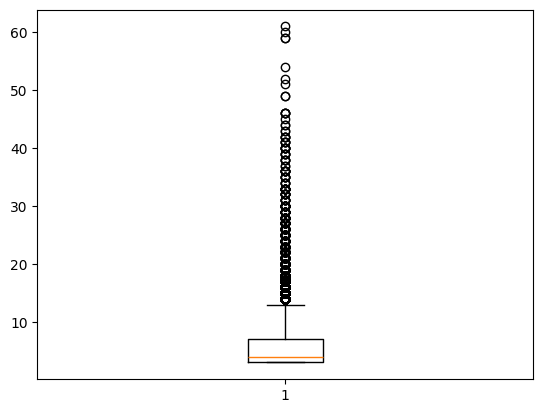

In [29]:
plt.boxplot(sum_feat)

From below pic we can see that most entrees from 3 to 9. median is 4.

In [30]:
data[data.iloc[:,2]!="0"].shape[0]

6003

Ass we see, data with first entry just 6000.

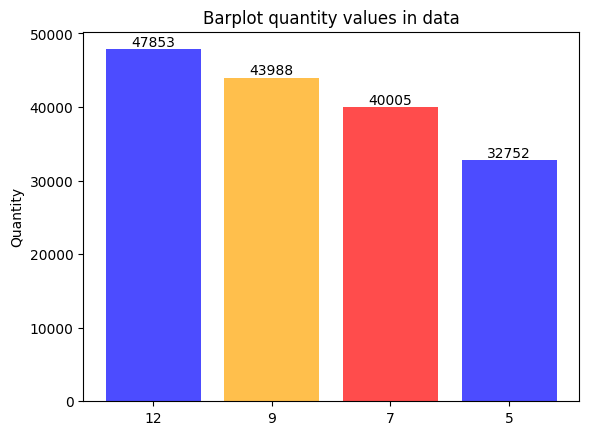

In [31]:

# Calculating quantity rows that equal to 12, 9, 7, 5
count_12 = (sum_feat <= 12).sum()
count_9 = (sum_feat <= 9).sum()
count_7 = (sum_feat <= 7).sum()
count_5 = (sum_feat <= 5).sum()

# Data for barplot
counts = [count_12, count_9, count_7, count_5]
labels = ['12', '9', "7", "5"]


# Creating barplot
plt.bar(labels, counts, color=['blue', 'orange', "red"], alpha=0.7)

# Adding labels
plt.ylabel('Quantity')
plt.title('Barplot quantity values in data')

# Show values under bar
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

how much unique labels in target

In [32]:
labels_count = data_test["target"]

In [33]:
labels_count = labels_count.value_counts()

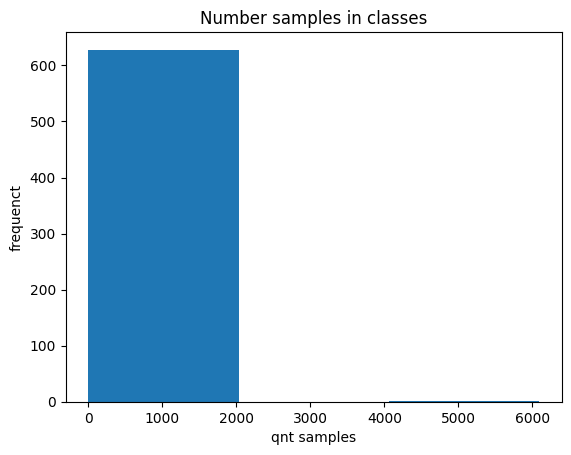

In [72]:
import matplotlib.pyplot as plt


plt.hist(labels_count, bins=3)  # 'bins' quantity columns
plt.xlabel("qnt samples")
plt.ylabel("frequenct")
plt.title("Number samples in classes")
plt.show()


from this picture we can see that many sample with very low frequently entrees, and it can influence on accuracy of model

create list with labels, that accured less than 50 times to use it in future like filter to delete this samples

In [35]:
#create list with labels, that accured less than 50 times
low_class = labels_count[labels_count<50]

In [36]:
low_class

,count
target,
622,49
185,49
481,49
620,49
549,49
...,...
270,1
6,1
12,1


In [37]:
list_filt_clas = low_class.index.tolist()

In [38]:
len(list_filt_clas)

345

let's see how much unique values in data

In [39]:
ip_uniq = data[1].value_counts()

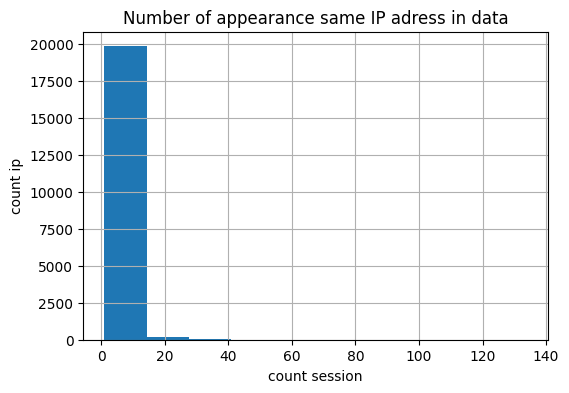

In [40]:
plt.figure(figsize=[6,4])

plt.title("Number of appearance same IP adress in data")

plt.ylabel("count ip")
plt.xlabel("count session")

ip_uniq.hist()

plt.show()

from this plot we see, that most same ip adresses appear in the data about 40 times

In [41]:
scaler = StandardScaler()

In [42]:
data_scaled = scaler.fit_transform(feature_columns)

In [43]:
tsne = TSNE(random_state=42)

In [44]:
# make data representation by tsne

data_repr = tsne.fit_transform(data_scaled)

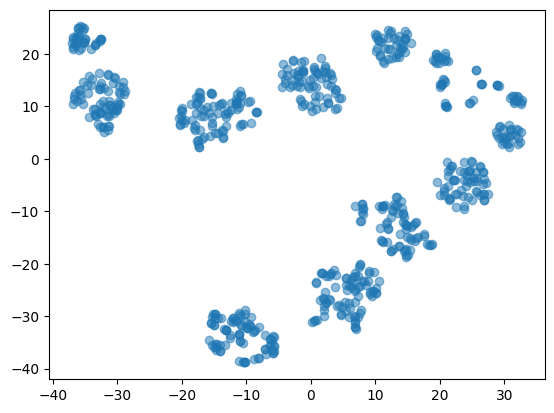

In [45]:
# plot data
plt.scatter(data_repr[:, 0], data_repr[:, 1], alpha=0.5)

from this plot we can see, that in Chicago restaurants can be splitted into (near) 12 clusters

#Data cleaning

Some
sessions don't have a known end point.  This is marked by -1 in the
end point field.

In [46]:
#filter sessions without known end point
data_test = data_test[data_test["target"]!="-1"]

In [47]:
# Deleting values "target", from low_class list
data_test["target"] = data_test["target"].apply(lambda x: None if x in low_class else x)

In [48]:
#add column with sum values features
data_test["sum_feat"] = sum_feat

In [49]:
#filter all values that more 9
data_test = data_test[data_test["sum_feat"]<9]

In [50]:
#cut useless columns
data_test = data_test.loc[:, list(data_test.columns[:9]) + ["target"]]

In [51]:
data_test

,1,2,3,4,5,6,7,8,9,target
0,www-c09.proxy.gnn.com,0,560L,110L,0,0,0,0,0,110
1,foley.ripco.com,0,423L,77L,0,0,0,0,0,77
2,foley.ripco.com,0,633N,633N,159P,159P,0,0,0,475
3,foley.ripco.com,0,441L,537L,0,0,0,0,0,537
4,pslip103d.egr-ri.ids.net,0,90M,90M,76L,476L,0,0,0,476
...,...,...,...,...,...,...,...,...,...,...
50666,204.189.237.218,0,192L,0,0,0,0,0,0,505
50667,216.176.149.182,0,100N,17N,0,0,0,0,0,107
50669,207.229.148.187,0,369L,0,0,0,0,0,0,303
50670,12.75.149.51,0,369L,632L,133L,336L,0,0,0,378


In [52]:
data_test.iloc[0,:].isna().sum()

0

In [53]:
# #convert target to numeric type
# data_test["target"] = pd.to_numeric(data_test["target"], errors='coerce')

In [54]:
data_test = data_test.dropna(axis=0)

In [55]:
data_test["target"].isna().sum()

0

#train-test split

In [57]:
X = data_test.astype(str).drop(columns=[1, "target"])[:20000]
y = data_test["target"][:20000]

In [58]:
len(X), len(y)

(20000, 20000)

##Target encoder

In [59]:
te = TargetEncoder(random_state=42).set_output(transform="pandas")

In [60]:
data_transformed = te.fit_transform(X,y)

##split data

In [61]:
X_train, X_test, y_train, y_test = train_test_split(data_transformed,y, train_size=0.8, shuffle=True,
                                                    random_state=42)

#Train reccomendation system

In [62]:
knn = KNeighborsClassifier()

In [63]:
scaler = StandardScaler()

In [64]:
pipeline = make_pipeline(scaler, knn)

In [65]:
pipeline

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [66]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

#Evaluate

In [67]:
from sklearn.metrics import roc_auc_score

In [68]:
labels = np.unique(y_train)
score = roc_auc_score(y_test, pipeline.predict_proba(X_test), multi_class="ovo",)
print(f"the roc_auc_score is: {score}")

the roc_auc_score is: 0.6739506021044407
